# Kelly Criteriom
## Use Index of representative asset classes
#### Developed-Emerging Equity, Real Estate, Commmodity, Treasury, Corporate Bond, TIPS are included
#### Result is driven from 2010 to 2021 market data

#### Kelly rule has a long history in gambling because it provides guidance on how much to stake on each of an (infinite) sequence of bets with varying (but favorable) odds to maximize terminal wealth. It was published as A New Interpretation of the Information Rate in 1956 by John Kelly who was a colleague of Claude Shannon's at Bell Labs. He was intrigued by bets placed on candidates at the new quiz show The $64,000 Question, where a viewer on the west coast used the three-hour delay to obtain insider information about the winners.

#### Kelly drew a connection to Shannon's information theory to solve for the bet that is optimal for long-term capital growth when the odds are favorable, but uncertainty remains. His rule maximizes logarithmic wealth as a function of the odds of success of each game, and includes implicit bankruptcy protection since log(0) is negative infinity so that a Kelly gambler would naturally avoid losing everything.

In [82]:
import warnings
warnings.filterwarnings('ignore')

In [83]:
import os
import sys
from pathlib import Path

import numpy as np
from numpy.linalg import inv
from numpy.random import dirichlet
import pandas as pd

from sympy import symbols, solve, log, diff
from scipy.optimize import minimize_scalar, newton, minimize
from scipy.integrate import quad
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns
from utils.yahoo_stock_data import yahoo_data


In [84]:
hdf_data_dir = os.path.join('G:','My Drive','.data_machine_learning_for_trading')
hdf_data_store = Path('G:','My Drive','.data_machine_learning_for_trading', 'assets.h5')

In [85]:
with pd.HDFStore(hdf_data_store) as store:
    sp500 = store['sp500/stooq'].close


In [86]:
annual_returns = sp500.resample('A').last().pct_change().dropna().to_frame('sp500')
return_params = annual_returns.sp500.rolling(25).agg(['mean', 'std']).dropna()
annual_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 69 entries, 1951-12-31 to 2019-12-31
Freq: A-DEC
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sp500   69 non-null     float64
dtypes: float64(1)
memory usage: 1.1 KB


In [87]:
sp500

Date
1950-01-03      16.66
1950-01-04      16.85
1950-01-05      16.93
1950-01-06      16.98
1950-01-07      17.09
               ...   
2019-12-24    3223.38
2019-12-26    3239.91
2019-12-27    3240.02
2019-12-30    3221.29
2019-12-31    3230.78
Name: close, Length: 17700, dtype: float64

In [88]:
hdf_data_store = Path('G:','My Drive','.data_machine_learning_for_trading', 'assets.h5')
with pd.HDFStore(hdf_data_store) as store:
    sp500_stocks = store['sp500/stocks'].index
    prices = store['quandl/wiki/prices'].adj_close.unstack('ticker').filter(sp500_stocks)


In [89]:
prices

ticker,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,...,WTW,WYNN,XEL,XLNX,XYL,YUM,ZBRA,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
1962-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-21,NaN,65.65,62.42,112.45,292.31,162.03,71.61,42.62,226.85,116.36,...,65.70,178.92,44.46,75.67,79.34,82.81,143.46,114.38,55.10,84.10
2018-03-22,NaN,64.48,60.93,98.10,286.39,150.23,69.76,41.94,220.52,113.14,...,64.68,175.54,44.57,73.94,77.38,82.18,138.29,111.38,53.07,82.06
2018-03-23,NaN,62.45,59.50,97.46,283.99,147.35,68.04,42.05,215.02,109.20,...,63.06,175.88,43.74,71.87,75.69,81.68,136.35,107.44,51.23,80.60


In [90]:
monthly_returns = prices.loc['1988':'2017'].resample('M').last().pct_change().dropna(how='all').dropna(axis=1)
stocks = monthly_returns.columns
monthly_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 359 entries, 1988-02-29 to 2017-12-31
Freq: M
Columns: 197 entries, MMM to XEL
dtypes: float64(197)
memory usage: 555.3 KB


In [91]:
# sp500.filter(monthly_returns.loc['2010':].index).pct_change().add(1).cumprod().sub(1).to_frame('SP500').plot(ax=ax, legend=True)

#### Kelly began by analyzing games with a binary win-lose outcome. The key variables are:,
- b: The odds define the amount won for a \$1 bet.
  (odds = 5/1  implies a 5 dollars gain if the bet wins, plus recovery of the 1 dollar capital)
- p: The probability defines the likelihood of a favorable outcome.,
- f: The share of the current capital to bet.
- V: The value of the capital as a result of betting.

#### The Kelly rule aims to maximize the value's growth rate, G, of infinitely-repeated bets :

#### "$$G=\\lim_{N\\rightarrow\\infty}=\\frac{1}{N}\\log\\frac{V_N}{V_0}$$"


In [92]:
share, odds, probability = symbols('share odds probability')
Value = probability * log(1 + odds * share) + (1 - probability) * log(1 - share)
solve(diff(Value, share), share)


[(odds*probability + probability - 1)/odds]

In [93]:
f, p = symbols('f p')
y = p * log(1 + f) + (1 - p) * log(1 - f)
solve(diff(y, f), f)



[2*p - 1]

### Load Data of each asset classes
##### Use representative ETF to model strategy
##### Data should be in yld format [rows : Dates, Columns : Asset Classes, yld = log(currnet_period_price/previous_period_price]

In [94]:
asset_class_ticker =[
    "IVV",  # iShares Core S&P 500 ETF                              2000-05-15
    "VEA",  # Vanguard FTSE Developed Markets ETF                    2007-07-02
    "VWO",  # Vanguard FTSE Emerging Markets ETF                    2005-03-04
    "TLT",  # iShares 20+ Year Treasury Bond ETF                    2002-07-22
    "TIP",  # iShares TIPS Bond ETF                                 2003-12-04
    "LQD",  # iShares iBoxx $ Investment Grade Corporate Bond ETF   2002-07-22
    "DBC",  # Invesco DB Commodity Index Tracking Fund              2006-02-03
    "XAR",  # SPDR® S&P® Aerospace & Defense ETF                    2011-09-28
    "XLB",  # The Materials Select Sector SPDR® Fund                1998-12-16
    "XLE",  # The Energy Select Sector SPDR® Fund                   1998-12-22
    "XLF",  # The Financial Select Sector SPDR® Fund                1998-12-22
    "XLI",  # The Industrial Select Sector SPDR® Fund               1998-12-22
    "XLK",  # The Technology Select Sector SPDR® Fund               1998-12-22
    "XME",  # SPDR® S&P® Metals & Mining ETF                        2006-06-23
    "XLP",  # The Consumer Staples Select Sector SPDR® Fund         1998-12-22
    "XLY",  # The Consumer Discretionary Select Sector SPDR® Fund   1998-12-22
    "XLU",  # The Utilities Select Sector SPDR® Fund                1998-12-22
    "XLV",  # The Health Care Select Sector SPDR® Fund              1998-12-22
    "XPH",  # SPDR® S&P® Pharmaceuticals ETF                        2006-06-22
    "XBI",  # SPDR® S&P® Biotech ETF                                2006-02-06
    "RWR",  # SPDR® Dow Jones® REIT ETF                             2001-04-23
    "RWX"   # SPDR® Dow Jones® International Real Estate ETF        2006-12-15
]

In [96]:
data_setting = {
    'start' : '2013-02-01',
    'end' : '2022-02-01',
    'ticker_list': asset_class_ticker,
}

data = yahoo_data(**data_setting)
yield_df = data.yahoo_stock_data_loading()
yield_df

,IVV,VEA,VWO,TLT,TIP,LQD,DBC,XAR,XLB,XLE,...,XLK,XME,XLP,XLY,XLU,XLV,XPH,XBI,RWR,RWX
Date,,,,,,,,,,,,,,,,,,,,,
2013-02-01,0.010435,0.007928,0.006732,-0.012985,-0.004885,-0.002595,0.003864,-0.009703,0.012301,0.009308,...,0.011224,0.011397,0.008137,0.005785,0.002734,0.007923,0.011605,0.010096,0.005698,0.003848
2013-02-04,-0.010919,-0.018172,-0.012929,0.012809,0.006489,0.003369,-0.003499,-0.007042,-0.009620,-0.009478,...,-0.013118,-0.011043,-0.009416,-0.012297,-0.006816,-0.011098,-0.009669,-0.009474,-0.001976,-0.013419
2013-02-05,0.009244,0.004420,0.002936,-0.008887,-0.002893,-0.002015,0.003862,0.008788,0.005112,0.008664,...,0.011588,-0.004330,0.011950,0.010642,0.002745,0.010990,0.009433,0.014505,-0.002640,0.006072
2013-02-06,0.001318,0.000000,-0.002477,0.008191,0.001161,0.002608,-0.001399,0.003973,0.001017,0.000641,...,-0.000337,0.019684,0.001342,0.002186,0.003011,-0.000232,0.002951,-0.002072,0.002383,0.000483
2013-02-07,-0.001185,-0.007701,-0.008126,-0.002224,-0.000910,0.000335,-0.003853,-0.000304,-0.005335,-0.002563,...,0.000000,-0.005387,0.005360,-0.002181,0.001365,-0.003701,-0.007192,-0.010797,-0.003433,-0.006274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-26,-0.002314,-0.004728,-0.010410,-0.012094,-0.006347,-0.006789,0.002256,-0.012794,-0.010440,-0.001684,...,0.005873,-0.026402,-0.007613,-0.004847,-0.008196,-0.005226,-0.007803,-0.019589,-0.013284,-0.001494
2022-01-27,-0.005213,-0.006609,-0.008870,0.018363,0.004072,0.002279,0.004953,-0.027823,0.003396,0.010890,...,-0.006888,-0.015599,0.006729,-0.024240,0.008864,0.002587,-0.009771,-0.045541,-0.013822,-0.002095
2022-01-28,0.024448,0.004574,0.001665,0.000349,0.003499,0.001098,0.000896,0.006153,0.005801,-0.004248,...,0.043731,0.008532,0.011765,0.021802,0.012063,0.020411,0.021661,0.035902,0.028031,0.004498


,IVV,VEA,VWO,TLT,TIP,LQD,DBC,XAR,XLB,XLE,...,XLK,XME,XLP,XLY,XLU,XLV,XPH,XBI,RWR,RWX
Date,,,,,,,,,,,,,,,,,,,,,
2013-02-01,0.010435,0.007927,0.006733,-0.012985,-0.004885,-0.002596,0.003864,-0.009703,0.012301,0.009308,...,0.011225,0.011397,0.008136,0.005785,0.002734,0.007924,0.011605,0.010096,0.005698,0.003849
2013-02-04,-0.010919,-0.018172,-0.012929,0.012809,0.006490,0.003369,-0.003499,-0.007042,-0.009620,-0.009479,...,-0.013118,-0.011043,-0.009416,-0.012297,-0.006816,-0.011098,-0.009669,-0.009474,-0.001977,-0.013420
2013-02-05,0.009244,0.004420,0.002936,-0.008887,-0.002893,-0.002014,0.003862,0.008788,0.005113,0.008664,...,0.011588,-0.004330,0.011950,0.010643,0.002745,0.010989,0.009432,0.014505,-0.002640,0.006072
2013-02-06,0.001318,0.000000,-0.002477,0.008192,0.001161,0.002607,-0.001399,0.003974,0.001017,0.000641,...,-0.000337,0.019684,0.001342,0.002185,0.003011,-0.000231,0.002951,-0.002072,0.002383,0.000483
2013-02-07,-0.001185,-0.007701,-0.008127,-0.002224,-0.000911,0.000335,-0.003853,-0.000305,-0.005335,-0.002562,...,0.000000,-0.005387,0.005360,-0.002180,0.001365,-0.003701,-0.007192,-0.010797,-0.003433,-0.006274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-26,-0.002314,-0.004728,-0.010410,-0.012094,-0.006347,-0.006789,0.002256,-0.012794,-0.010440,-0.001684,...,0.005873,-0.026402,-0.007613,-0.004847,-0.008196,-0.005226,-0.007803,-0.019589,-0.013284,-0.001494
2022-01-27,-0.005213,-0.006609,-0.008870,0.018363,0.004072,0.002279,0.004953,-0.027823,0.003396,0.010890,...,-0.006888,-0.015599,0.006729,-0.024240,0.008864,0.002587,-0.009771,-0.045541,-0.013822,-0.002095
2022-01-28,0.024448,0.004574,0.001665,0.000349,0.003499,0.001098,0.000896,0.006153,0.005801,-0.004248,...,0.043731,0.008532,0.011765,0.021802,0.012063,0.020411,0.021661,0.035902,0.028031,0.004498


In [97]:
def kelly_allocation_mp(asset_ylds):
    cov = asset_ylds.cov()
    precision_matrix = pd.DataFrame(np.linalg.inv(cov), index=asset_ylds.columns.tolist(), columns=asset_ylds.columns.tolist())
    # np.linalg.inv(cov) returns inverse matrix in numpy matrix type
    kelly_allocation = asset_ylds.mean().dot(precision_matrix)
    kelly_allocation = kelly_allocation.div(kelly_allocation.sum())

    print("start date : ", asset_ylds.index.tolist()[0], " end date : ", asset_ylds.index.tolist()[-1])
    kelly_allocation.sort_values(ascending=False).plot.barh(figsize=(8, 10))
    plt.yticks(fontsize=12)
    sns.despine()
    plt.tight_layout()

    print(type(kelly_allocation))
    return kelly_allocation

In [98]:
def monthly_rebalance_strategy(yld_df):
    yld_df_12m = yld_df.resample('1M').first()
    KL_weight = []

    for i in range(len(yld_df_12m)):
        if i < 12:
            KL_weight.append("")
        else:
            KL_weight.append(kelly_allocation_mp(yld_df.iloc[i-12:i-1]).tolist())

    yld_df_12m['KL_Weight'] = KL_weight
    # rebalance portfolio every 12 month, thus first 12 month cannot make position
    yld_df_12m = yld_df_12m.iloc[12:,:]

    KL_Return = []
    ret = 0

    for i in range(len(yld_df_12m)):
        # investment return of asset class * weight of asset class
        for j in range(yld_df_12m.shape[1]-1):
            ret += (yld_df_12m.iloc[i,j]) * ((yld_df_12m['KL_Weight'].iloc[i])[j])

        KL_Return.append(ret)
        ret = 0

    yld_df_12m['KL_Return'] = KL_Return

    return yld_df_12m

start date :  2013-02-01 00:00:00  end date :  2013-02-15 00:00:00
<class 'pandas.core.series.Series'>
start date :  2013-02-04 00:00:00  end date :  2013-02-19 00:00:00
<class 'pandas.core.series.Series'>
start date :  2013-02-05 00:00:00  end date :  2013-02-20 00:00:00
<class 'pandas.core.series.Series'>
start date :  2013-02-06 00:00:00  end date :  2013-02-21 00:00:00
<class 'pandas.core.series.Series'>
start date :  2013-02-07 00:00:00  end date :  2013-02-22 00:00:00
<class 'pandas.core.series.Series'>
start date :  2013-02-08 00:00:00  end date :  2013-02-25 00:00:00
<class 'pandas.core.series.Series'>
start date :  2013-02-11 00:00:00  end date :  2013-02-26 00:00:00
<class 'pandas.core.series.Series'>
start date :  2013-02-12 00:00:00  end date :  2013-02-27 00:00:00
<class 'pandas.core.series.Series'>
start date :  2013-02-13 00:00:00  end date :  2013-02-28 00:00:00
<class 'pandas.core.series.Series'>
start date :  2013-02-14 00:00:00  end date :  2013-03-01 00:00:00
<class

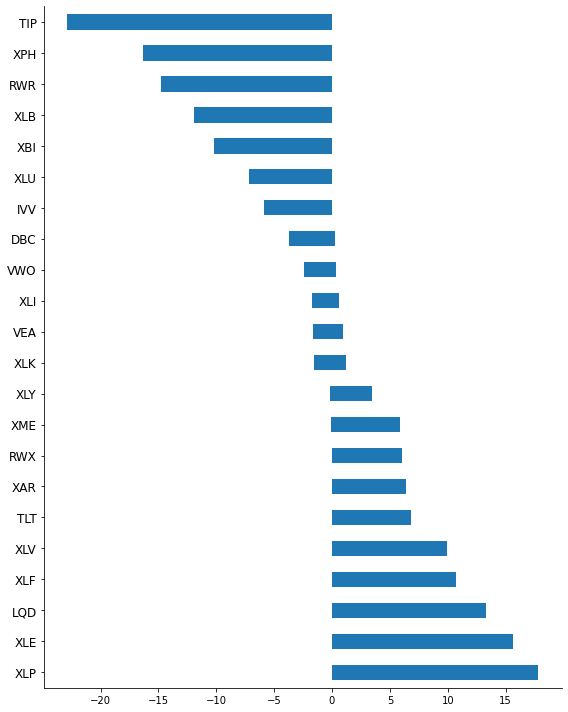

In [99]:
monthly_rebal_strategy = monthly_rebalance_strategy(yield_df)


In [76]:
monthly_rebal_strategy

,IVV,VEA,VWO,TLT,TIP,LQD,DBC,XAR,XLB,XLE,...,XLK,XME,XLP,XLY,XLU,XLV,XPH,XBI,RWR,RWX
Date,,,,,,,,,,,,,,,,,,,,,
2013-02-01,0.010435,0.007928,0.006733,-0.012985,-0.004885,-0.002595,0.003864,-0.009703,0.012301,0.009309,...,0.011224,0.011398,0.008136,0.005785,0.002734,0.007924,0.011605,0.010096,0.005698,0.003849
2013-02-04,-0.010919,-0.018172,-0.012929,0.012809,0.006490,0.003369,-0.003499,-0.007042,-0.009620,-0.009479,...,-0.013118,-0.011044,-0.009416,-0.012297,-0.006816,-0.011098,-0.009669,-0.009474,-0.001977,-0.013420
2013-02-05,0.009244,0.004420,0.002935,-0.008887,-0.002893,-0.002015,0.003862,0.008788,0.005113,0.008664,...,0.011589,-0.004330,0.011950,0.010643,0.002745,0.010989,0.009433,0.014505,-0.002640,0.006073
2013-02-06,0.001318,0.000000,-0.002477,0.008191,0.001160,0.002608,-0.001399,0.003974,0.001017,0.000641,...,-0.000337,0.019684,0.001342,0.002185,0.003011,-0.000231,0.002951,-0.002072,0.002382,0.000483
2013-02-07,-0.001185,-0.007701,-0.008126,-0.002224,-0.000910,0.000335,-0.003853,-0.000305,-0.005336,-0.002563,...,0.000000,-0.005387,0.005360,-0.002181,0.001365,-0.003701,-0.007192,-0.010797,-0.003433,-0.006274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-26,-0.002314,-0.004728,-0.010410,-0.012094,-0.006347,-0.006789,0.002256,-0.012794,-0.010440,-0.001684,...,0.005873,-0.026402,-0.007613,-0.004847,-0.008196,-0.005226,-0.007803,-0.019589,-0.013284,-0.001494
2022-01-27,-0.005213,-0.006609,-0.008870,0.018363,0.004072,0.002279,0.004953,-0.027823,0.003396,0.010890,...,-0.006888,-0.015599,0.006729,-0.024240,0.008864,0.002587,-0.009771,-0.045541,-0.013822,-0.002095
2022-01-28,0.024448,0.004574,0.001665,0.000349,0.003499,0.001098,0.000896,0.006153,0.005801,-0.004248,...,0.043731,0.008532,0.011765,0.021802,0.012063,0.020411,0.021661,0.035902,0.028031,0.004498


compute return and standard deviation of S&P500 index


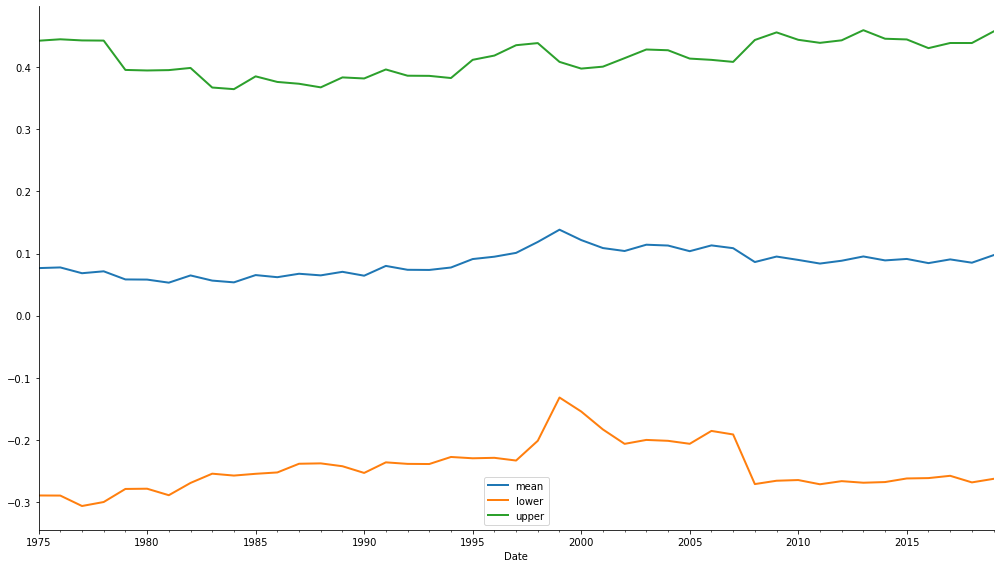

In [19]:
# draw 2 sigma band of S&P500 index data
return_ci = (return_params[['mean']]
                .assign(lower=return_params['mean'].sub(return_params['std'].mul(2)))
                .assign(upper=return_params['mean'].add(return_params['std'].mul(2))))

return_ci.plot(lw=2, figsize=(14, 8))
plt.tight_layout()
sns.despine();

## Kelly Rule for a Single Asset - Index Returns
#### In a financial market context, both outcomes and alternatives are more complex, but the Kelly rule logic does still apply. It was made popular by Ed Thorp, who first applied it profitably to gambling (described in Beat the Dealer) and later started the successful hedge fund Princeton/Newport Partners.

#### With continuous outcomes, the growth rate of capital is defined by an integrate over the probability distribution of the different returns that can be optimized numerically. We can solve this expression (see book) for the optimal f* using the scipy.optimize module:


In [21]:
def norm_integral(f, mean, std):
    val, er = quad(lambda s: np.log(1 + f * s) * norm.pdf(s, mean, std),
                               mean - 3 * std,
                               mean + 3 * std)
    return -val

def norm_dev_integral(f, mean, std):
    val, er = quad(lambda s: (s / (1 + f * s)) * norm.pdf(s, mean, std), m-3*std, mean+3*std)
    return val

def get_kelly_share(data):
    solution = minimize_scalar(norm_integral,
                        args=(data['mean'], data['std']),
                        bounds=[0, 2],
                        method='bounded')
    return solution.x

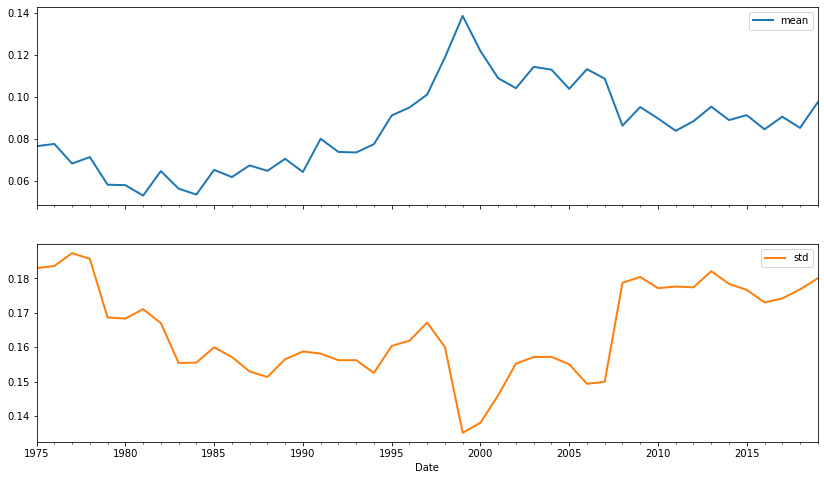

In [22]:
annual_returns['f'] = return_params.apply(get_kelly_share, axis=1)
return_params.plot(subplots=True, lw=2, figsize=(14, 8));

### Performance Evaluation

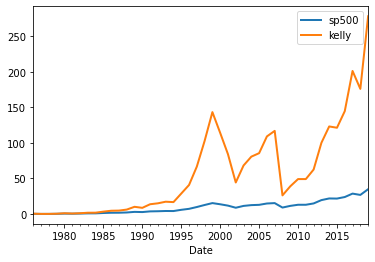

In [23]:
(annual_returns[['sp500']]
 .assign(kelly=annual_returns.sp500.mul(annual_returns.f.shift()))
 .dropna()
 .loc['1900':]
 .add(1)
 .cumprod()
 .sub(1)
 .plot(lw=2));

#### Compute Kelly Fraction

In [25]:
m = .058
s = .216

In [26]:
# Option 1: minimize the expectation integral
sol = minimize_scalar(norm_integral, args=(m, s), bounds=[0., 2.], method='bounded')
print('Optimal Kelly fraction: {:.4f}'.format(sol.x))

Optimal Kelly fraction: 1.1974


In [27]:
# Option 2: take the derivative of the expectation and make it null
x0 = newton(norm_dev_integral, .1, args=(m, s))
print('Optimal Kelly fraction: {:.4f}'.format(x0))


Optimal Kelly fraction: 1.1974


## Kelly Rule for Multiple Assets
#### We will use an example with various equities. E. Chan (2008) illustrates how to arrive at a multi-asset application of the Kelly Rule, and that the result is equivalent to the (potentially levered) maximum Sharpe ratio portfolio from the mean-variance optimization.

#### The computation involves the dot product of the precision matrix, which is the inverse of the covariance matrix, and the return matrix:

#### compute precision matrix

In [33]:
monthly_returns

ticker,MMM,AOS,ABT,ABMD,ADM,ADBE,ADP,AFL,AIG,APD,...,WBA,DIS,WEC,WFC,WST,WDC,WY,WHR,WMB,XEL
date,,,,,,,,,,,,,,,,,,,,,
1988-02-29,-0.016015,0.107451,0.066667,0.016250,0.051373,0.094340,0.084912,-0.025965,-0.079937,0.163636,...,0.119147,0.056091,-0.014866,0.077426,-0.137391,0.234043,0.134737,0.072335,0.142330,-0.023039
1988-03-31,-0.025424,0.080028,-0.098462,0.291513,-0.036145,0.068966,-0.081417,0.170749,-0.073440,-0.059891,...,0.007528,-0.036657,-0.024438,-0.050562,-0.084677,0.026207,-0.101345,-0.053571,0.000000,-0.024129
1988-04-30,0.028174,-0.057049,-0.020838,0.000000,0.125000,0.129032,-0.058824,-0.068923,-0.027975,0.077986,...,0.062267,-0.025849,0.020202,-0.014675,0.005232,0.024866,-0.025207,0.028302,0.159273,-0.003984
1988-05-31,0.053712,0.000000,0.016217,-0.154286,-0.038069,0.007143,-0.031250,-0.074686,0.090733,-0.059529,...,-0.050158,0.008696,0.050463,0.027195,0.082966,0.000000,-0.020000,-0.026255,-0.036158,0.041667
1988-06-30,0.068826,0.105263,-0.029545,-0.028153,-0.063800,0.141844,0.048455,-0.045000,0.026432,0.119104,...,0.100775,0.086207,0.014548,0.124260,-0.025085,0.008525,0.117551,0.095238,0.028976,0.012866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-31,0.021547,0.039963,0.035787,0.018300,-0.012934,0.059185,-0.104617,0.040694,-0.075936,0.022652,...,0.015262,-0.079414,0.044061,-0.046321,-0.018715,0.037007,-0.012417,-0.028889,-0.064506,0.046290
2017-09-30,0.027310,0.067157,0.047507,0.118037,0.028800,-0.038541,0.032141,-0.014052,0.020477,0.040242,...,-0.052515,-0.025988,-0.037412,0.079890,0.105928,-0.015541,0.053304,0.074700,0.019577,-0.037031
2017-10-31,0.096665,-0.001514,0.021227,0.144247,-0.038579,0.174152,0.063483,0.030716,0.052452,0.060825,...,-0.141803,-0.007710,0.073431,0.017951,0.054983,0.033218,0.055245,-0.111201,-0.050317,0.046492


In [30]:
cov = monthly_returns.cov()
precision_matrix = pd.DataFrame(np.linalg.inv(cov), index=stocks, columns=stocks)
# np.linalg.inv(cov) returns inverse matrix in numpy matrix type
kelly_allocation = monthly_returns.mean().dot(precision_matrix)
kelly_allocation.describe()


count    197.000000
mean       0.251290
std        3.526408
min      -10.221545
25%       -1.905738
50%        0.026558
75%        2.385162
max       10.333651
dtype: float64

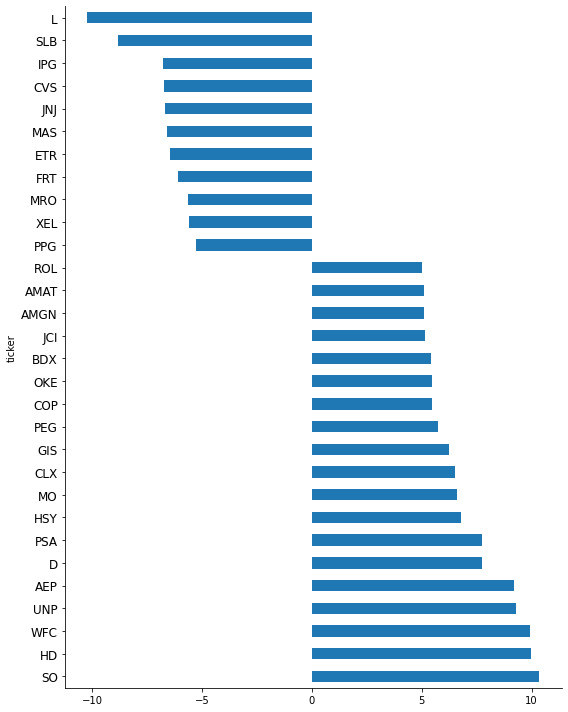

In [31]:
kelly_allocation[kelly_allocation.abs()>5].sort_values(ascending=False).plot.barh(figsize=(8, 10))
plt.yticks(fontsize=12)
sns.despine()
plt.tight_layout();


 #### performance evaluation of SP500 and Kelly criteriom evaluation

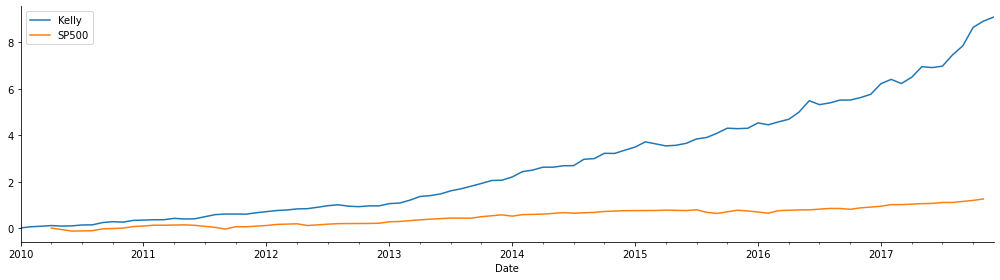

In [32]:
ax = monthly_returns.loc['2010':].mul(kelly_allocation.div(kelly_allocation.sum())).sum(1).to_frame('Kelly').add(1).cumprod().sub(1).plot(figsize=(14,4));
sp500.filter(monthly_returns.loc['2010':].index).pct_change().add(1).cumprod().sub(1).to_frame('SP500').plot(ax=ax, legend=True)
plt.tight_layout()
sns.despine();


